In [2]:
import meep as mp
import math
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

mp.verbosity(0)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

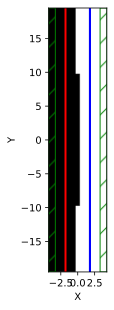

In [3]:
grid = 0.02
res = 1 / grid
wvl = 0.55  # wavelength
height = np.pi / (2 * np.pi) * wvl / (1.45 - 1)  # height of grating

dpml = 1.0  # PML thickness
dsub = 3.0  # substrate thickness
dpad = 3.0  # padding between grating and PML
gp = 39.0  # grating period

gh = height  # grating height
gdc = 0.5  # grating duty cycle

sx = dpml + dsub + gh + dpad + dpml
sy = gp

air = mp.Medium(index=1.0)
SiO2 = mp.Medium(index=1.45)

cell_size = mp.Vector3(sx, sy, 0)
pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]


fcen = 1 / wvl  # center frequency
df = 0.2 * fcen  # frequency width

src_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=src_pt,
        size=mp.Vector3(y=sy),
    )
]

k_point = mp.Vector3(0, 0, 0)

symmetries = [mp.Mirror(mp.Y)]

geometry = [
    mp.Block(
        material=SiO2,
        size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
        center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(gh, gdc * gp, mp.inf),
        center=mp.Vector3(-0.5 * sx + dpml + dsub + 0.5 * gh),
    ),
]


sim = mp.Simulation(
    resolution=res,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    k_point=k_point,
    default_material=air,
    sources=sources,
    symmetries=symmetries,
    geometry=geometry,
)

nfreq = 21
mon_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad)
flux_mon = sim.add_flux(
    fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy))
)
# near2far
n2f = sim.add_near2far(
    fcen, df, 1, mp.Near2FarRegion(center=mon_pt, size=mp.Vector3(y=sy))
)
f = plt.figure(dpi=120)
sim.plot2D(ax=f.gca())
plt.show()

In [4]:
height

0.6111111111111113

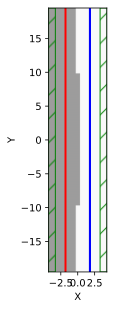

In [4]:
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)

sim.run(
    mp.at_every(1, Animate),
    until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-5),
)

# sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

In [5]:
Animate.to_jshtml(fps=5)

Output_angle of grating coupler: 0.9241107778208826 degree
max of far field: 0.00038093744170339736


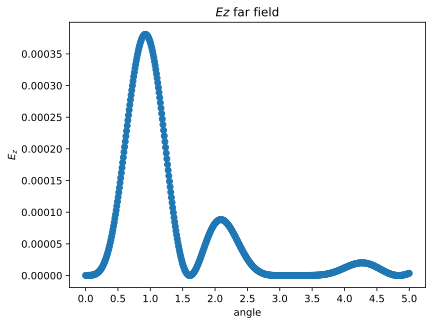

In [6]:
ff_distance = 1e6  # far-field distance from near-field monitor
ff_angle = 5  # far-field cone angle
ff_npts = 500  # number of far-field points
ff_length = ff_distance * math.tan(math.radians(ff_angle))
ff_res = ff_npts / ff_length
ff_lengths = np.linspace(0, ff_length, ff_npts)
angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]
points = [mp.Vector3(ff_distance, f) for f in ff_lengths]
ff_supercell = sim.get_farfields(
    n2f,
    ff_res,
    center=mp.Vector3(ff_distance, 0.5 * ff_length),
    size=mp.Vector3(y=ff_length),
)
rel_enh = np.abs(ff_supercell["Ez"] ** 2)

figure, ax = plt.subplots()
plt.plot(angles, rel_enh, "-o")
plt.xticks(np.linspace(0, 5, 11))
plt.title(r"$ Ez $ far field")
ax.set_xlabel("angle")
ax.set_ylabel(r"$ E_z $")
index = np.argmax(rel_enh)

print(f"Output_angle of grating coupler: {angles[index]} degree")
print(f"max of far field: {np.max(rel_enh)}")

In [7]:
ff_distance = 1e6  # far-field distance from near-field monitor
ff_angle = 5  # far-field cone angle
ff_npts = 1000  # number of far-field points
# single-side far-field length
ff_length = ff_distance * math.tan(math.radians(ff_angle))  # far-field length
# [-ff_length, ff_length]
ff_lengths = np.linspace(-ff_length, ff_length, ff_npts)  # far-field lengths
# resolution
ff_res = ff_npts / (2 * ff_length)  # far-field length resolution

ff = sim.get_farfields(
    n2f,
    ff_res,
    center=mp.Vector3(ff_distance, 0),
    size=mp.Vector3(y=2 * ff_length),
)
# [-angle, angle]
angles = [math.degrees(math.atan(f)) for f in ff_lengths / ff_distance]
rel_enh = np.abs(ff["Ez"])

figure, ax = plt.subplots()
plt.plot(angles, rel_enh, "-o")
plt.title(r"$ Ez $ far field")
ax.set_xlabel("angle")
ax.set_ylabel(r"$ E_z $")
plt.xticks(np.linspace(-ff_angle, ff_angle, 11))

index = np.argmax(rel_enh)
print(f"Output_angle of grating coupler: {angles[index]} degree")
print(f"max of far field: {np.max(rel_enh)}")

Output_angle of grating coupler: -0.9282023414364361 degree
max of far field: 0.019516542094856947


([<matplotlib.axis.XTick at 0x7fd3141a6550>,
 [Text(-5.0, 0, '−5'),
  Text(-4.0, 0, '−4'),
  Text(-3.0, 0, '−3'),
  Text(-2.0, 0, '−2'),
  Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4'),
  Text(5.0, 0, '5')])

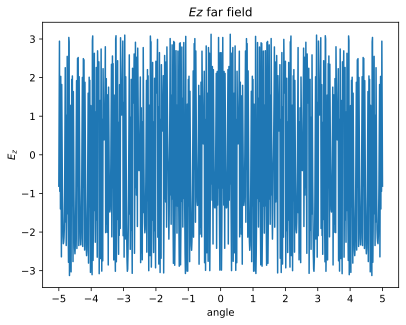

In [8]:
figure, ax = plt.subplots()
plt.plot(angles, np.angle(ff["Ez"]), "-")
plt.title(r"$ Ez $ far field")
ax.set_xlabel("angle")
ax.set_ylabel(r"$ E_z $")
plt.xticks(np.linspace(-ff_angle, ff_angle, 11))

In [9]:
np.rad2deg(np.arcsin(0.55/(2*39)))

0.40401204969411986